[203, 257]
[200, 251]
[201, 250]
[204, 250]
[201, 248]
[206, 251]
[210, 251]
[199, 248]
[203, 252]
[209, 250]
[204, 248]
background dose=0.6618283881375387


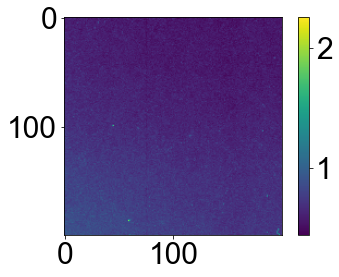

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import scipy
import pandas as pd
from PIL import Image
import os
from skimage.feature import peak_local_max
import imageio
from scipy.optimize import curve_fit
import itertools
from scipy.signal import find_peaks

%matplotlib inline

#maxdose=18
maxdose=8e8
energy=200


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 30}


matplotlib.rc('font', **font)


#Get and calibrate films################################################################3
film_r=[]
film_g=[]
film_b=[]
directory = 'D:/Desktop/thesis/GRID at CERN/GRID/10_11_22/10_11_22_3dayscans/'
for i in np.arange(1,11+1):
    input_image = np.array(Image.open(directory+'film00'+str(i)+'.tif').convert("RGB")).T
    film_r.append(input_image[0].T)
    film_g.append(input_image[1].T)
    film_b.append(input_image[2].T)
#apply calibration corrections
#Joe's values 
a_r = 1.08979454e-02;b_r = 4.31528862e-04;c_r = 4.52890034e+00
a_g = 1.30365440e-02;b_g = 2.18523305e-04;c_g = 5.47818342e+00
a_b = 1.83975349e-02;b_b = 4.03633386e-04;c_b = 1.10176866e+01


film_r=np.array(film_r)/65535
film_r=np.array([(a_r - c_r * i) / (i - b_r) for i in film_r])
film_g=np.array(film_g)/65535
film_g=np.array([(a_g - c_g * i) / (i - b_g) for i in film_g])
film_b=np.array(film_b)/65535
film_b=np.array([(a_b - c_b * i) / (i - b_b) for i in film_b])
###########################################################################################

#Background films
background=[np.array(Image.open(directory+'film_bkg0'+str(i)+'.tif').convert("RGB")).T for i in np.arange(34,37)]
input_image = np.mean(background,axis=0)
bkg_r=np.array([input_image[0].T]).squeeze()
bkg_g=np.array([input_image[1].T]).squeeze()
bkg_b=np.array([input_image[2].T]).squeeze()

bkg_r=np.array(bkg_r)/65535
bkg_r=np.array([(a_r - c_r * i) / (i - b_r) for i in bkg_r]).clip(min=0)
bkg_g=np.array(bkg_g)/65535
bkg_g=np.array([(a_g - c_g * i) / (i - b_g) for i in bkg_g]).clip(min=0)
bkg_b=np.array(bkg_b)/65535
bkg_b=np.array([(a_b - c_b * i) / (i - b_b) for i in bkg_b]).clip(min=0)

bkg_dose_r=np.mean(bkg_r[100:300,100:300])
bkg_dose_g=np.mean(bkg_g[100:300,100:300])
bkg_dose_b=np.mean(bkg_b[100:300,100:300])

figure(1)
plt.imshow(bkg_g[100:300,100:300])
plt.colorbar()
###############################################################################

#Open beam analysis
OB=np.array(film_g-bkg_dose_g)/(6.8e-9/0.3) #factor is total charge/charge per bunch/rep rate
OBxfilm=np.arange(13,63+1,5) ########### film locations

OBpeaks=[]
OBpeaks_err=[]
profiles1d=[]
for k in range(len(OB)):
    #find indices of maxima
    xy=[]
    xy = peak_local_max(scipy.ndimage.gaussian_filter(OB[k,100:300,100:300],sigma=10),threshold_abs=2,num_peaks=1)
    xy=[xy[0,1]+100,xy[0,0]+100]
    if k==0:
        OBfirstpeak=xy[1]
    print(xy)
    #plot 2d profiles
#     figure(k+80,figsize=(8,8))
#     profile=OB[k,xy[1]-125:xy[1]+126,xy[0]-125:xy[0]+126]
#     im=plt.imshow(profile,vmin=0,vmax=maxdose,cmap='inferno',extent=(0,len(profile)/300*25.4,0,len(profile)/300*25.4))
#     plt.colorbar(label='Dose rate (Gy/s)',fraction=0.046, pad=0.04)
#     #plt.scatter(125/300*25.4,125/300*25.4,s=20,c='red')
#     #plt.text(16,19.5,str(OBxfilm[k])+'mm',c='white')
#     #plt.text(8.7,19.5,str(energy)+'MeV',c='white')
#     plt.xlabel('x (mm)')
#     plt.ylabel('y (mm)')
#     plt.savefig('D:Desktop/thesis/film_analysis/OB'+str(k)+'_'+str(energy)+'.png')
    profiles1d.append(np.mean([OB[k,i] for i in np.arange(xy[1]-10,xy[1]+11)],axis=0))
    
    #ROI for PDDs
    OBpeaks.append(np.mean([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)]))
    OBpeaks_err.append(np.std([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)])/np.sqrt(len([OB[k,i,j] for i in np.arange(xy[1]-10,xy[1]+10) for j in np.arange(xy[0]-10,xy[0]+10)])))
OBpeaks=np.array(OBpeaks)
OBpeaks_err=np.array(OBpeaks_err)

#animation
frames=[]
for k in range(len(OB)):
    frames.append(imageio.imread('D:Desktop/thesis/film_analysis/OB'+str(k)+'_'+str(energy)+'.png'))
imageio.mimsave('D:Desktop/thesis/film_analysis/OB'+str(energy)+'.gif', frames,'GIF-FI',quantizer='nq',duration=0.5)

print('background dose='+str(bkg_dose_g))

#Gaussian fit
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def gauss_fit(xdata,ydata):
    mean = np.mean(xdata)
    sigma = np.std(xdata)
    popt,pcov = curve_fit(gaus,xdata,ydata,p0=[max(ydata), mean, sigma])
    plt.plot(np.arange(0,len(ydata)),gaus(xdata,*popt),label='Gaussian fit',lw=3)
    print(popt[-1]/300*25.4)
    

savethis=np.array([OB,OBxfilm,OBpeaks,OBpeaks_err,np.arange(0,len(OB[0,OBfirstpeak]))/300*25.4,profiles1d],dtype=object)
np.save('D:Desktop/thesis/200MeVOB.npy',savethis)



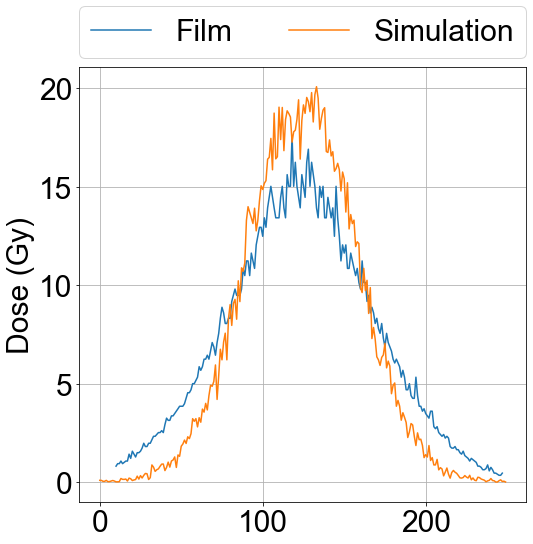

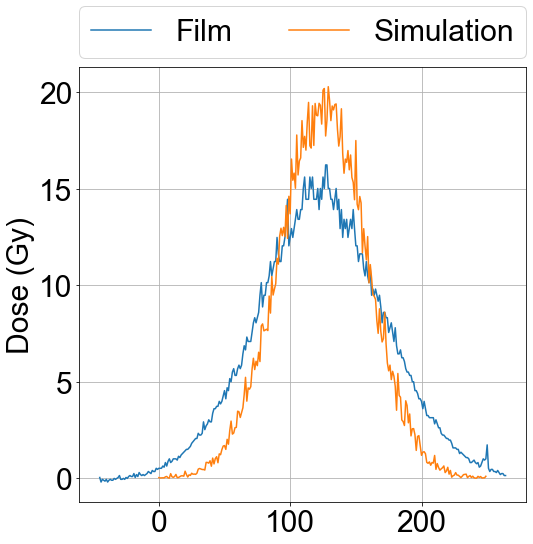

In [40]:
figure(78,figsize=(8,8))
plt.plot(np.arange(0,len(OB[0,257,90:328]))+10,OB[0,257,90:328]*(6.8e-9/0.3),label='Film')
#gauss_fit(np.arange(0,len(OB[0,257,90:328])),OB[0,257,90:328])
simgaussx=np.load('D:Desktop/thesis/sims_gauss_x.npy')
plt.plot(simgaussx,label='Simulation')
plt.grid()
plt.ylabel('Dose (Gy)')
l4 = plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
mode="expand", borderaxespad=0, ncol=2)

figure(79,figsize=(8,8))
plt.plot(np.arange(0,len(OB[0,90:400,203]))-45,OB[0,90:400,203]*(6.8e-9/0.3),label='Film')
#gauss_fit(np.arange(0,len(OB[0,90:400,203])),OB[0,90:400,203])
simgaussy=np.load('D:Desktop/thesis/sims_gauss_y.npy')
plt.plot(simgaussy,label='Simulation')
plt.grid()
plt.ylabel('Dose (Gy)')
plt.legend()
l4 = plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
mode="expand", borderaxespad=0, ncol=2)



[] (0,)


ValueError: cannot reshape array of size 0 into shape (441,2)

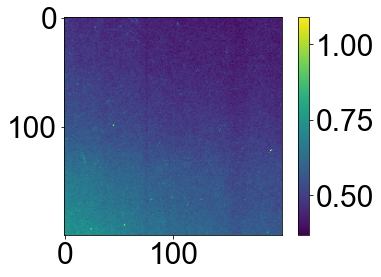

<Figure size 576x576 with 0 Axes>

In [8]:
maxdose=8e8
energy=200
#Get and calibrate films#########################################
film_r=[]
film_g=[]
film_b=[]
directory = 'D:/Desktop/thesis/GRID at CERN/GRID/10_11_22/'

for i in np.arange(22,32+1):
    input_image = np.array(Image.open(directory+'film0'+str(i)+'.tif').convert("RGB")).T
    film_r.append(input_image[0].T)
    film_g.append(input_image[1].T)
    film_b.append(input_image[2].T)
#apply calibration corrections
#Joe's values 
a_r = 1.08979454e-02;b_r = 4.31528862e-04;c_r = 4.52890034e+00
a_g = 1.30365440e-02;b_g = 2.18523305e-04;c_g = 5.47818342e+00
a_b = 1.83975349e-02;b_b = 4.03633386e-04;c_b = 1.10176866e+01


film_r=np.array(film_r)/65535
film_r=np.array([(a_r - c_r * i) / (i - b_r) for i in film_r])
film_g=np.array(film_g)/65535
film_g=np.array([(a_g - c_g * i) / (i - b_g) for i in film_g])
film_b=np.array(film_b)/65535
film_b=np.array([(a_b - c_b * i) / (i - b_b) for i in film_b])
#########################################################################

#Background films
background=[np.array(Image.open(directory+'bkg_0'+str(i)+'.tif').convert("RGB")).T for i in np.arange(33,44)]
input_image = np.mean(background,axis=0)
bkg_r=np.array([input_image[0].T]).squeeze()
bkg_g=np.array([input_image[1].T]).squeeze()
bkg_b=np.array([input_image[2].T]).squeeze()

bkg_r=np.array(bkg_r)/65535
bkg_r=np.array([(a_r - c_r * i) / (i - b_r) for i in bkg_r]).clip(min=0)
bkg_g=np.array(bkg_g)/65535
bkg_g=np.array([(a_g - c_g * i) / (i - b_g) for i in bkg_g]).clip(min=0)
bkg_b=np.array(bkg_b)/65535
bkg_b=np.array([(a_b - c_b * i) / (i - b_b) for i in bkg_b]).clip(min=0)

bkg_dose_r=np.mean(bkg_r[100:300,100:300])
bkg_dose_g=np.mean(bkg_g[100:300,100:300])
bkg_dose_b=np.mean(bkg_b[100:300,100:300])

figure(1)
plt.imshow(bkg_g[100:300,100:300])
plt.colorbar()

##########################################

#GRID 200 MeV
GRID=np.flip(film_g-bkg_dose_g)/(2.73e-8)
xfilm=np.arange(13,63+1,5) ######### film locations

mean_peaks=[]
ROI=[]
peak_error=[]
valley_error=[]
for d in range(len(GRID)):
    
    #Find peak indices
    xy = peak_local_max(scipy.ndimage.gaussian_filter(GRID[d,100:300,100:300],sigma=3),threshold_abs=1,num_peaks=1)
    xy=[xy[0,1]+100,xy[0,0]+100]
    if k==0:
        firstpeak=xy[1]
    #plot 2d profiles
    figure(k+30,figsize=(8,8))
    profile=GRID[d,xy[1]-125:xy[1]+126,xy[0]-125:xy[0]+126]
    col_avgs=sum(profile[0:-1])
    row_avgs=sum(profile.T[0:-1])
    peak_rows=find_peaks(row_avgs,distance=6)[0]
    peak_cols=find_peaks(col_avgs,distance=6)[0]
    peak_cols=peak_cols[int(np.where((peak_cols>=120) & ( peak_cols <=130))[0]):int(np.where((peak_cols>=120) & ( peak_cols <=130))[0])]
    peak_rows=peak_rows[int(np.where((peak_rows>=120) & ( peak_rows <=130))[0]):int(np.where((peak_rows>=120) & ( peak_rows <=130))[0])]

    peak_peaks=[[i,j] for i in peak_rows for j in peak_cols]
    
    for k,w in peak_peaks:
        ROI.append([[k,w],[k,w+1],[k+1,w],[k-1,w],[k,w-1],[k-1,w-1],[k+1,w+1],[k-1,w+1],[k+1,w-1]])
    print(ROI,np.shape(ROI))
    peaks=[profile[j][i] for i,j in np.reshape(ROI,(7*7*9,2))] 
    mean_peaks.append(np.mean(peaks))
    peak_error.append(np.std(peaks)/np.sqrt(len(peaks)))
    figure(8+d,figsize=(9,8))
    plt.imshow(profile,cmap='magma')
    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')
    plt.colorbar(shrink=0.75,label='Dose rate (Gy/s)')
    for i,j in np.reshape(ROI,(225,2)):
        plt.scatter(j,i,marker='s',c='white',alpha=0.8)
    STD=[]
    ROI_dose=[]
    for i in ROI:
        temp=[]
        for k in i:
            temp.append(profile[k[0]][k[1]])
        ROI_dose.append(temp)
    for i in ROI_dose:
        STD.append(np.std(i))
    #peak_error.append(np.sqrt(sum([i**2 for i in STD]))/25) 
    ROI=[]
mean_peaks=np.array(mean_peaks)


    
#valleys
mean_valleys=[]
for d in range(len(GRID)):
    col_avgs=sum(profile[0:-1])
    row_avgs=sum(profile.T[0:-1])
    
    peak_rows=find_peaks(row_avgs,distance=6)[0] #need for limiting valley area search
    peak_cols=find_peaks(col_avgs,distance=6)[0]
    peak_cols=peak_cols[int(np.where((peak_cols>=120) & ( peak_cols <=130))[0])-2:int(np.where((peak_cols>=120) & ( peak_cols <=130))[0])+3]
    peak_rows=peak_rows[int(np.where((peak_rows>=120) & ( peak_rows <=130))[0])-2:int(np.where((peak_rows>=120) & ( peak_rows <=130))[0])+3]

    valley_rows=find_peaks(row_avgs[peak_rows[0]:peak_rows[-1]]*-1,distance=6)[0]+peak_rows[0]
    valley_cols=find_peaks(col_avgs[peak_cols[0]:peak_cols[-1]]*-1,distance=6)[0]+peak_cols[0]

    vert_valleys=[]
    hori_valleys=[]
    for i in valley_cols:
        vert_valleys.append(np.mean(profile.T[i][peak_cols[0]:peak_cols[-1]]))
    for i in valley_rows:
        hori_valleys.append(np.mean(profile[i][peak_rows[0]:peak_rows[-1]]))
        
    figure(8+d,figsize=(9,8))
    plt.hlines(valley_rows,peak_cols[0],peak_cols[-1],colors='cyan',alpha=0.8,lw=4)
    plt.vlines(valley_cols,peak_rows[0],peak_rows[-1],colors='cyan',alpha=0.8,lw=4)

    mean_valleys.append((np.mean(hori_valleys)+np.mean(vert_valleys))/2)
    valley_error.append(np.std(np.array([hori_valleys,vert_valleys]).flatten())/np.sqrt(len(np.array([hori_valleys,vert_valleys]).flatten())))
pvdr=mean_peaks/mean_valleys
valley_error=np.array(valley_error);peak_error=np.array(peak_error)
pvdr_error=np.sqrt((valley_error/mean_valleys)**2+(peak_error/mean_peaks)**2)*pvdr





print('background dose='+str(bkg_dose_g))

#animation
# frames=[]
# for k in range(len(GRID)):
#     frames.append(imageio.imread('D:Desktop/thesis/film_analysis/GRID'+str(k)+'_'+str(energy)+'.png'))
# imageio.mimsave('D:Desktop/thesis/film_analysis/GRID'+str(energy)+'.gif', frames,'GIF-FI',quantizer='nq',duration=0.5)

x1=np.array(peaks)
x2=np.array(peaks_std)
x3=np.array((np.arange(0,len(GRID[0,firstpeak]))-peakindgrid+peakindOB)/300*25.4)
x4=np.array(GRID[0,firstpeak])
x5=np.array(pvdr)
x6=np.array(pvdr_std)
savethis=np.array([GRID,x1,x2,x3,x4,x5,x6,valleys,valleys_std],dtype=object)
# np.save('D:Desktop/thesis/200MeV.npy',savethis)



IndexError: index 0 is out of bounds for axis 0 with size 0